# Implémentez un modèle de scoring par Frejus IBATTA


Data Science - Projet 7 - Juillet 2023

Modélisation sur Google collab

Etude réalisée en langage Python

*Data source* : https://www.kaggle.com/c/home-credit-default-risk/data

---

## Rappel de la mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

## Code de la modélisation
Dans le Notebook Jupyter nous avons vu l'exploration, ainsi que le prétraitement des données. Ici nous utiliserons un GPU pour effectuer les modélisations Catboost, LightGBM & XGBoost. Ici nous sommes en Google Colab PRO, donc l'accès au GPU est illimité… _L'offre free ne permet pas de mener à bien ce projet, les limites ont rapidement étaient atteintes pour effectuer les différents tests._


In [1]:
#Test de l'activation du GPU
#Si le GPU est activé, il donnera la sortie suivante - '/ device: GPU: 0 '
import tensorflow as tf
tf.test.gpu_device_name ()

''

In [2]:
#Appareils utilisés lors de l'exécution du notebook dans le cloud
from tensorflow.python.client import device_lib
device_lib.list_local_devices ()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10066363089440954033
 xla_global_id: -1]

In [3]:
#Vérification de la RAM
!pip install -U scikit-learn

---

In [4]:
!pip install xgboost 

In [5]:
!pip install catboost

In [6]:
import lightgbm as lgb

In [7]:
!rm -rf LightGBM

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
!apt-get install -y libboost-all-dev

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
!git clone --recursive https://github.com/microsoft/LightGBM
%cd LightGBM
!git checkout tags/v3.3.3
!mkdir -p build

C:\Users\ksoka\Downloads\LightGBM


fatal: destination path 'LightGBM' already exists and is not an empty directory.


M	external_libs/compute
M	external_libs/eigen
M	external_libs/fast_double_parser
M	external_libs/fmt


HEAD is now at a0a617df add patch from #5159
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file build already exists.
Error occurred while processing: build.


In [10]:
!cd /content/LightGBM && cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/


The system cannot find the path specified.


In [11]:
ls

 Volume in drive C is OS
 Volume Serial Number is F404-AC24

 Directory of C:\Users\ksoka\Downloads\LightGBM

10/22/2023  01:39 PM    <DIR>          .
10/25/2023  02:30 PM    <DIR>          ..
10/19/2023  12:44 PM             1,295 .appveyor.yml
10/19/2023  12:44 PM    <DIR>          .ci
10/19/2023  12:39 PM               501 .editorconfig
10/19/2023  12:44 PM    <DIR>          .github
10/19/2023  12:44 PM             7,105 .gitignore
10/19/2023  12:39 PM               457 .gitmodules
10/19/2023  12:39 PM    <DIR>          .nuget
10/19/2023  12:39 PM               268 .readthedocs.yaml
10/19/2023  12:44 PM            13,531 .vsts-ci.yml
10/19/2023  12:44 PM    <DIR>          build
10/19/2023  12:44 PM            13,755 build_r.R
10/19/2023  12:44 PM             7,498 build-cran-package.sh
10/22/2023  01:40 PM    <DIR>          catboost_info
10/19/2023  12:44 PM    <DIR>          cmake
10/19/2023  12:44 PM            18,652 CMakeLists.txt
10/19/2023  12:39 PM             4,728 CODE_OF_C

In [12]:
!ls /content/LightGBM/python-package

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [13]:
!cd /content/LightGBM && make -j$(nproc)

The system cannot find the path specified.


In [14]:
!cd /content/LightGBM/python-package && python3 setup.py install --precompile --gpu

The system cannot find the path specified.


In [15]:
!mkdir -p /etc/OpenCL/vendors
!echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

The syntax of the command is incorrect.
The system cannot find the path specified.


In [16]:
!nvcc --version

'nvcc' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn


In [18]:
pip install --upgrade imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install -U imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import seaborn as sns
import time, pickle

In [2]:
from zipfile import ZipFile

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [4]:
from imblearn.over_sampling import SMOTE

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

In [8]:
from imblearn.pipeline import make_pipeline, Pipeline

In [9]:
import pandas as pd
import seaborn as sns
import time, pickle

from zipfile import ZipFile

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")

In [10]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [11]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [12]:
import zipfile

# Ouvrir le fichier ZIP
z = ZipFile("C:\\Users\\ksoka\\Downloads\\data_train.zip")

data_train = pd.read_csv(z.open('data_train.csv'), index_col='SK_ID_CURR', encoding ='utf-8')
#data_train.drop('SK_ID_CURR', axis=1, inplace=True)
data_train.shape

(307511, 309)

In [13]:
TARGET = pd.read_csv("C:\\Users\\ksoka\\Downloads\\TARGET.csv",index_col='SK_ID_CURR')
TARGET.shape

(307511, 1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 309), (92254, 309), (215257, 1), (92254, 1))

### **Baseline model - Logistic Regression**
Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certains clients, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances=None):
    '''Cette fonction permet de créer une représentation graphique d'une matrice de confusion
    sklearn à l'aide d'une heatmap de la bibliothèque Seaborn, ainsi qu'une courbe ROC.'''

    fig = plt.figure(figsize=(12, 6))

    # Matrice de confusion
    plt.subplot(121)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title('Matrice de confusion')

    # Courbe ROC
    plt.subplot(122)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=2, label='Courbe ROC (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend()

    # Plot des importances des caractéristiques si disponible
    if feature_importances:
        plt.figure(figsize=(12, 4))
        feature_names = feature_importances.index
        feature_importance_values = feature_importances.values
        sns.barplot(x=feature_importance_values, y=feature_names, color='orange')
        plt.xlabel('Importance des caractéristiques')
        plt.ylabel('Caractéristiques')
        plt.title('Importance des caractéristiques')

    plt.tight_layout()
    plt.show()


In [18]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.6939
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

CPU times: total: 6.61 s
Wall time: 1.98 s


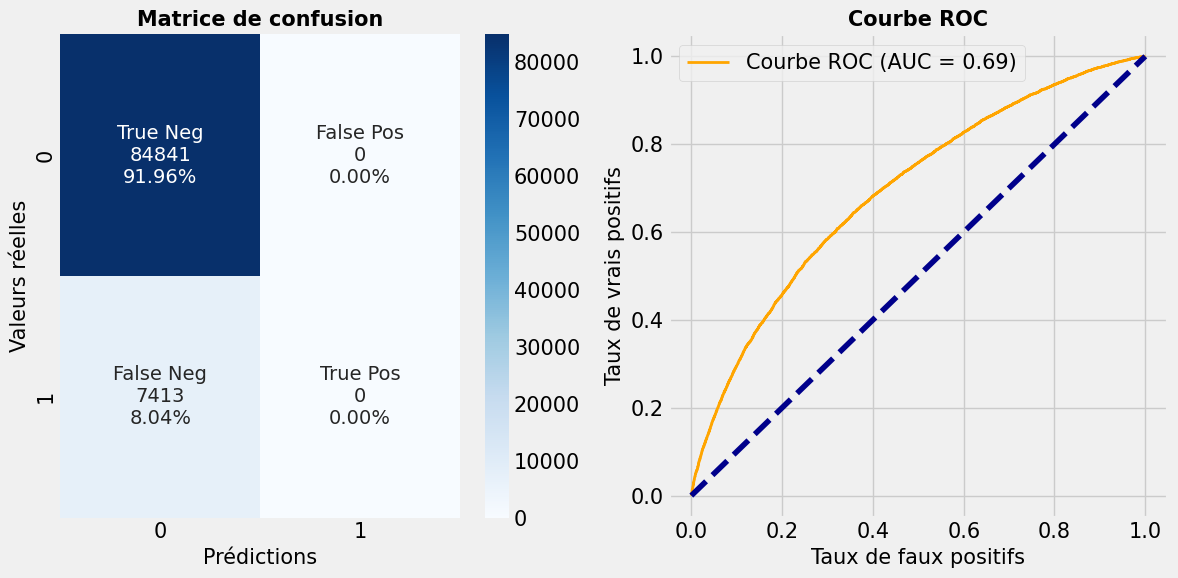

In [19]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..

Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français)  en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

**Oversampling Data Using SMOTE**

SMOTE with Imbalance Data using imblearn module



In [20]:
print("Label 1, Avant utilisation SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Avant utilisation SMOTE: {} ".format(sum(y_train==0)))

Label 1, Avant utilisation SMOTE: 17412 
Label 0, Avant utilisation SMOTE: 197845 


In [21]:
%%time

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

CPU times: total: 8.73 s
Wall time: 3.77 s


In [22]:
print("Label 1, Après utilisation SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, Après utilisation SMOTE: {}".format(sum(y_train_res==0)))

Label 1, Après utilisation SMOTE: 197845
Label 0, Après utilisation SMOTE: 197845


In [23]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7196
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     84841
         1.0       0.15      0.65      0.24      7413

    accuracy                           0.67     92254
   macro avg       0.55      0.66      0.52     92254
weighted avg       0.89      0.67      0.75     92254

CPU times: total: 23.3 s
Wall time: 6.51 s


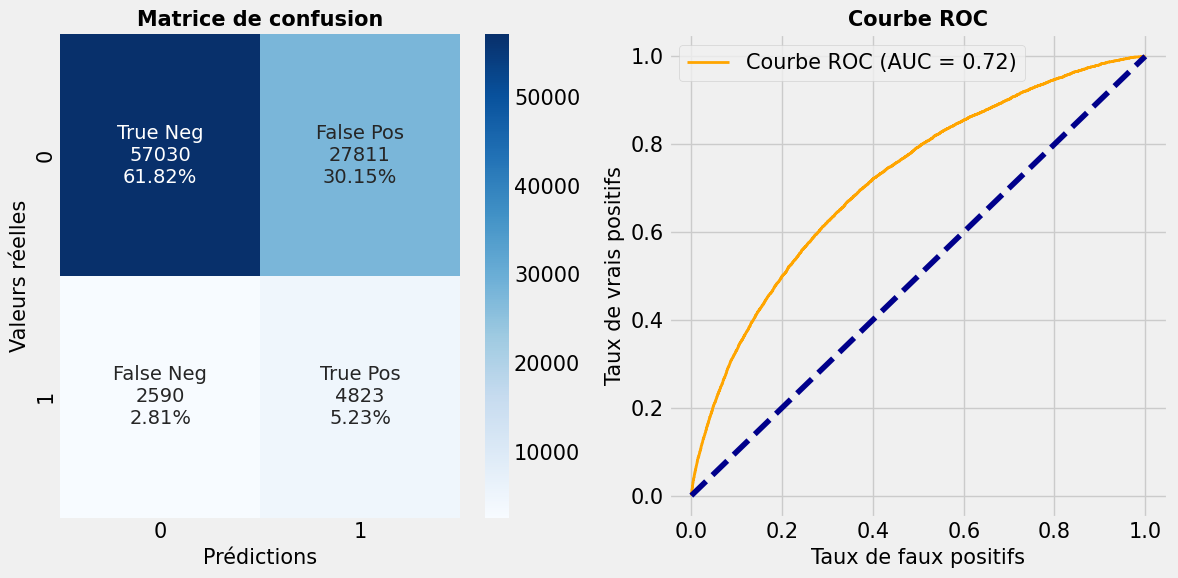

In [24]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Amélioration de l'AUC score 0.72 que nous prendrons comme baseline de travail pour la suite des essais…

### **Gradient Boosting**

La fonction suivante ``train_models`` peut calculer les métriques auc, accuracy, f1, precision et recall. On peut la modifier selon les besoins attendus, il suffit de se référer aux [Scoring de Classification de Scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [25]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [
    CatBoostClassifier(logging_level='Silent'),
    LGBMClassifier(),
    XGBClassifier()
]


Les modèles `CatBoostClassifier`, `LGBMClassifier`, et `XGBClassifier` sont des algorithmes d'apprentissage automatique populaires utilisés pour la classification, en particulier dans les compétitions de science des données et pour des applications pratiques. Voici une brève description de chacun de ces modèles :

1. **CatBoostClassifier** :
   - **CatBoost** est un algorithme de gradient boosting conçu spécifiquement pour les tâches de classification et de régression.
   - Il est développé par Yandex et se distingue par sa gestion automatique des variables catégorielles (d'où le "Cat" dans le nom). Il n'est pas nécessaire de prétraiter les données catégorielles, ce qui est un avantage majeur.
   - CatBoost gère également automatiquement les valeurs manquantes et possède des mécanismes intégrés de régularisation pour éviter le surajustement.
   - Il est reconnu pour sa capacité à gérer de grands ensembles de données et à obtenir de bonnes performances avec peu de réglages hyperparamétriques.

2. **LGBMClassifier (LightGBM)** :
   - **LightGBM** est un autre algorithme de gradient boosting qui est conçu pour être rapide et efficace en termes de mémoire. Il est développé par Microsoft.
   - LightGBM utilise une technique appelée "histogram-based learning", qui permet de réduire la quantité de mémoire nécessaire pour former le modèle, tout en accélérant le processus d'entraînement.
   - Il est efficace pour les ensembles de données volumineux et est souvent utilisé dans des compétitions de science des données pour sa rapidité et ses performances.
   - LightGBM propose également une gestion améliorée des données catégorielles.

3. **XGBClassifier (XGBoost)** :
   - **XGBoost**, ou Extreme Gradient Boosting, est un algorithme de gradient boosting qui a été l'un des pionniers dans l'utilisation de cette technique en science des données.
   - Il est extrêmement polyvalent et performant, offrant un large éventail d'options de configuration et de personnalisation.
   - XGBoost est connu pour sa capacité à gérer des ensembles de données hétérogènes, la régularisation avancée, et la gestion des valeurs manquantes.
   - Il est couramment utilisé en raison de ses performances élevées et de sa flexibilité.

Ces trois modèles partagent des similitudes en tant qu'algorithmes de gradient boosting, mais ils se distinguent par des fonctionnalités spécifiques et des avantages particuliers. Le choix entre ces modèles dépendra des caractéristiques de vos données, de vos besoins en termes de performances, et de votre préférence personnelle. Il est courant de les expérimenter tous pour déterminer celui qui fonctionne le mieux pour une tâche de classification donnée.

In [26]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }

    return output

Les paramètres de performance AUC (Area Under the ROC Curve), Accuracy (Exactitude), Precision (Précision), Recall (Rappel), et F1-score sont couramment utilisés pour évaluer la performance des modèles de classification. Voici comment on interprète ces mesures :

1. **AUC (Area Under the ROC Curve)** :
   - L'AUC est une mesure de la capacité d'un modèle à discriminer entre les classes positives et négatives. 
   - L'aire sous la courbe ROC (Receiver Operating Characteristic) varie de 0 à 1, où 1 représente un modèle parfait, et 0,5 représente un modèle qui ne fait pas mieux que le hasard.
   - Plus l'AUC est proche de 1, meilleur est le modèle pour la classification.

2. **Accuracy (Exactitude)** :
   - L'accuracy mesure la proportion de prédictions correctes parmi toutes les prédictions.
   - C'est le ratio des prédictions correctes (positives et négatives) sur l'ensemble des prédictions.
   - L'accuracy est simple à interpréter, mais elle peut être trompeuse si les classes sont déséquilibrées. Par exemple, si 95 % des échantillons appartiennent à la classe négative, un modèle qui prédit toujours la classe négative aura une accuracy de 95 %, mais cela ne signifie pas nécessairement qu'il est un bon modèle.

3. **Precision (Précision)** :
   - La précision mesure la proportion de vrais positifs parmi toutes les prédictions positives.
   - C'est le ratio des vrais positifs sur l'ensemble des prédictions positives (vrais positifs + faux positifs).
   - La précision indique la capacité du modèle à minimiser les faux positifs. C'est particulièrement important lorsque les faux positifs ont des conséquences coûteuses.

4. **Recall (Rappel)** :
   - Le rappel mesure la proportion de vrais positifs parmi toutes les instances réellement positives.
   - C'est le ratio des vrais positifs sur l'ensemble des vrais positifs + faux négatifs.
   - Le rappel indique la capacité du modèle à capturer la majorité des instances réellement positives. Il est important lorsque vous voulez éviter de manquer des cas positifs.

5. **F1-score** :
   - Le F1-score est une mesure qui combine à la fois la précision et le rappel en une seule métrique.
   - Il est calculé en utilisant la formule : F1 = 2 * (Precision * Recall) / (Precision + Recall).
   - Le F1-score est utile lorsque vous voulez trouver un équilibre entre la précision et le rappel. Un modèle avec un F1-score élevé est capable de fournir à la fois une précision élevée et une capture élevée des vrais positifs.

En résumé, ces métriques vous aident à évaluer différents aspects de la performance d'un modèle de classification. Le choix de la métrique dépendra de vos objectifs spécifiques et des conséquences de différentes erreurs de classification dans votre domaine d'application. Il est souvent recommandé d'examiner un ensemble de métriques pour avoir une vue d'ensemble de la performance du modèle.

In [27]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

# Initialisation des données des listes
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27714
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 301
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
CPU times: total: 3min 11s
Wall time: 2min 15s


In [29]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.777892,0.91944,0.486639,0.046675,0.08518,271.396423
1,LGBMClassifier,0.774506,0.920134,0.55102,0.03278,0.061879,18.336446
2,XGBClassifier,0.765503,0.919104,0.47133,0.055443,0.099215,22.885721


Nous allons comparer une nouvelle fois nos modèles, cette fois-ci l'entrainement se fera avec les données SMOTE.

In [28]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_res, X_test, y_train_res, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

# Initialisation des données des listes
models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_res.sort_values('AUC', ascending=False, inplace=True)

[LightGBM] [Info] Number of positive: 197845, number of negative: 197845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.232518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67559
[LightGBM] [Info] Number of data points in the train set: 395690, number of used features: 303
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
CPU times: total: 16min 33s
Wall time: 5min 24s


In [31]:
models_res

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.77064,0.919592,0.496887,0.053824,0.097128,553.563039
2,XGBClassifier,0.753275,0.918182,0.430341,0.056253,0.099499,60.781111
1,LGBMClassifier,0.75241,0.918865,0.398876,0.019156,0.036556,40.122764


XGBClassifier est le "plus performant" selon le couple métrique/temps.

### **Feature Selection - Recursive Feature Elimination**
Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec ``XGBClassifier`` qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 309 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

Le RFECV, qui signifie Recursive Feature Elimination with Cross-Validation (Élimination de Caractéristiques Récursive avec Validation Croisée en français), est une technique utilisée en apprentissage automatique pour sélectionner les meilleures caractéristiques (ou attributs) d'un ensemble de données. Il combine deux techniques : la récursion (Recursive Feature Elimination, RFE) et la validation croisée (Cross-Validation).

Voici ce que permet le RFECV :

1. **Sélection automatique de caractéristiques** : Le RFECV permet de sélectionner automatiquement les caractéristiques les plus importantes ou informatives dans un ensemble de données. Il évalue l'importance de chaque caractéristique en utilisant un modèle d'apprentissage automatique, généralement un modèle de régression ou de classification, puis élimine les caractéristiques les moins importantes.

2. **Validation croisée** : Pour évaluer l'importance de chaque caractéristique, le RFECV utilise la validation croisée. Il divise les données en plusieurs sous-ensembles (plis) et évalue les performances du modèle sur ces plis. Cela permet d'obtenir une estimation plus robuste de l'importance des caractéristiques, en évitant le surajustement.

3. **Élimination itérative** : Le RFECV élimine itérativement les caractéristiques les moins importantes à chaque étape de la récursion. Le processus commence avec toutes les caractéristiques, puis les caractéristiques les moins importantes sont supprimées une par une. Cela se répète jusqu'à ce qu'un nombre spécifié de caractéristiques soit atteint ou jusqu'à ce qu'il n'y ait plus de caractéristiques à éliminer.

4. **Estimation du nombre optimal de caractéristiques** : Le RFECV peut également aider à estimer le nombre optimal de caractéristiques à conserver pour obtenir les meilleures performances du modèle. Il utilise généralement la validation croisée pour comparer les performances du modèle avec différents ensembles de caractéristiques, en enlevant un nombre croissant de caractéristiques à chaque itération.

5. **Réduction de la dimensionnalité** : En éliminant les caractéristiques les moins importantes, le RFECV permet de réduire la dimensionnalité des données, ce qui peut contribuer à améliorer l'efficacité des modèles d'apprentissage automatique, réduire le temps de calcul et éviter le surajustement.

Le RFECV est particulièrement utile lorsque vous avez un grand nombre de caractéristiques et que vous souhaitez identifier celles qui contribuent le plus à la prédiction. C'est une technique de sélection de caractéristiques puissante, bien qu'elle puisse être coûteuse en termes de calcul, car elle nécessite de construire et d'évaluer le modèle plusieurs fois.

In [30]:
import time
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Start the timer
start = time.time()

# Define XGBClassifier parameters
xgb_params = {
    'objective': 'binary:logistic'
}

# Create and train RFECV with XGBClassifier without GPU
rfecv = RFECV(estimator=XGBClassifier(**xgb_params),
              step=5,
              cv=StratifiedKFold(5),
              scoring='roc_auc',
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

# Calculate the elapsed time
elapsed_time = time.time() - start
print('Elapsed time: {:.2f} seconds'.format(elapsed_time))


Fitting estimator with 309 features.
Fitting estimator with 304 features.
Fitting estimator with 299 features.
Fitting estimator with 294 features.
Fitting estimator with 289 features.
Fitting estimator with 284 features.
Fitting estimator with 279 features.
Fitting estimator with 274 features.
Fitting estimator with 269 features.
Fitting estimator with 264 features.
Fitting estimator with 259 features.
Fitting estimator with 254 features.
Fitting estimator with 249 features.
Fitting estimator with 244 features.
Fitting estimator with 239 features.
Fitting estimator with 234 features.
Fitting estimator with 229 features.
Fitting estimator with 224 features.
Fitting estimator with 219 features.
Fitting estimator with 214 features.
Fitting estimator with 209 features.
Fitting estimator with 204 features.
Fitting estimator with 199 features.
Fitting estimator with 194 features.
Fitting estimator with 189 features.
Fitting estimator with 184 features.
Fitting estimator with 179 features.
F

In [ ]:
import time
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


start = time.time()

# Définir les paramètres du XGBClassifier
xgb_params = {
    'objective': 'binary:logistic'
}

# Créer et entraîner le RFECV avec XGBClassifier sans le GPU
start = time.time()
rfecv = RFECV(estimator=XGBClassifier(**xgb_params),
              step=5,
              cv=StratifiedKFold(5),
              scoring='roc_auc',
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Temps écoulé : {}'.format(time.time()-start))


In [31]:
print("Nombre optimal de features : %d" % rfecv.n_features_)
print("Features sélectionnés: %s" % rfecv.support_[:20])
print("Ranking ou classement des features : %s" % rfecv.ranking_[:20])

Nombre optimal de features : 119
Features sélectionnés: [ True  True False False  True  True  True  True  True  True  True  True
  True  True False False  True False False False]
Ranking ou classement des features : [ 1  1 16 17  1  1  1  1  1  1  1  1  1  1 29 26  1 27 12 17]


RFECV conserve les features avec un Rank 1 > True. Ci-dessous une vérification de la sélection de Rank 1…

In [32]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

119
['NAME_CONTRACT_TYPE', 'PREV_APPL_MEAN_RATE_DOWN_PAYMENT', 'PREV_APPL_MEAN_DAYS_DECISION', 'PREV_APPL_MEAN_SELLERPLACE_AREA', 'PREV_APPL_MEAN_CNT_PAYMENT', 'PREV_APPL_MEAN_DAYS_FIRST_DRAWING', 'PREV_APPL_MEAN_DAYS_FIRST_DUE', 'PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 'PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 'PREV_APPL_MEAN_DAYS_LAST_DUE', 'PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL', 'PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT', 'PREV_APPL_MEAN_DAYS_TERMINATION', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT', 'PREV_APPL_MEAN_AMT_GOODS_PRICE', 'PREV_APPL_MEAN_AMT_CREDIT', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'PREVIOUS_LOANS_COUNT', 'PREV_BUR_MEAN_DAYS_CREDIT', 'PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 'PREV_BUR_MEAN_D

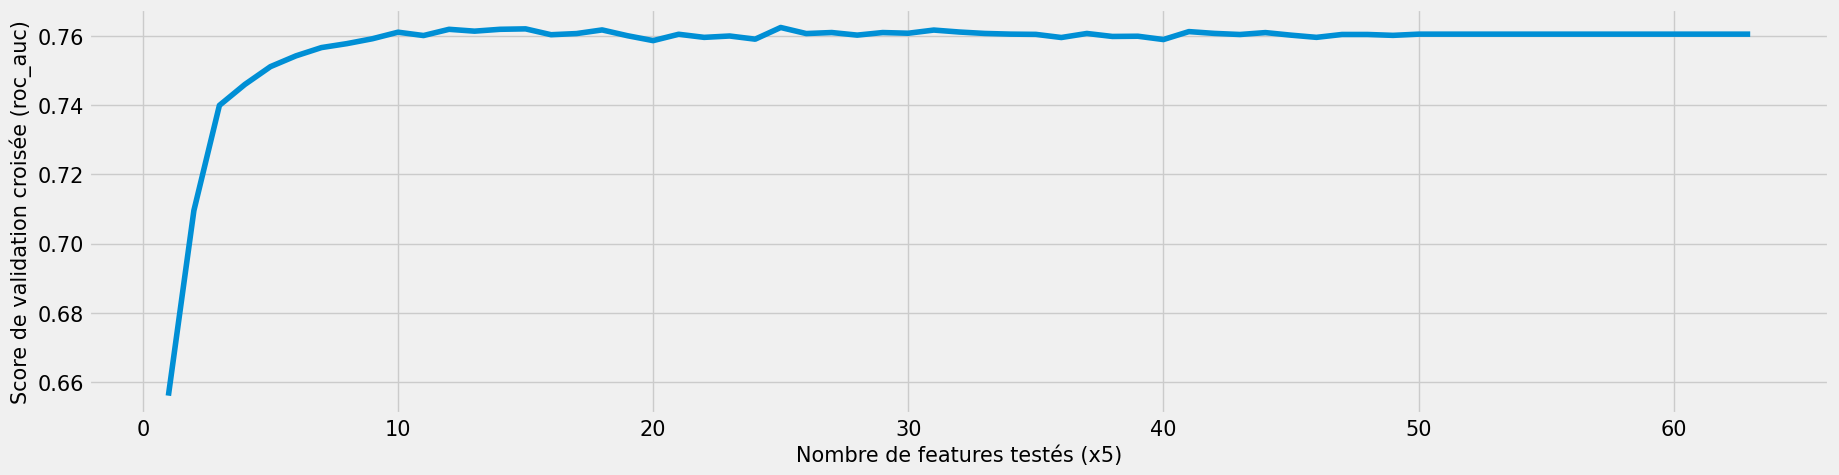

In [33]:
#Traçons le nombre de features en fonction des scores de validation croisée

step = 5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel('Nombre de features testés (x%d)' % step)
plt.ylabel('Score de validation croisée (roc_auc)')
plt.show()


RFECV explique l'importance des features sélectionnées en fonction de l'évolution du score AUC, comme l'atteste également le plot ci-dessus.

In [34]:
"#X_data est très important pour mettre en œuvre le graphique d'importance des fonctionnalités (features)..."
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape

(307511, 119)

Il est nécessaire de sauvegarder le dataset ``X_data`` de manière à pouvoir le réutiliser facilement…

In [35]:
#operation de fusion avec TARGET
X_data = X_data.merge(TARGET, left_index=True, right_index=True)

In [36]:
X_data.shape

(307511, 120)

In [37]:
pwd


'C:\\Users\\ksoka\\Downloads'

In [38]:
%%time
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv("C:\\Users\\ksoka\\Downloads\\X_data.zip", index=True, compression=compression_opts)

CPU times: total: 1min 25s
Wall time: 2min 30s


Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 149 best features identifiées. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [39]:
%%time
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv("C:\\Users\\ksoka\\Downloads\\X_data.sample.zip", index=True, compression=compression_opts)

CPU times: total: 7.77 s
Wall time: 15.3 s


In [40]:
%%time
X_data.sample(10000).to_csv("C:\\Users\\ksoka\\Downloads\\X_sample.csv", index=True)

CPU times: total: 1.47 s
Wall time: 2.77 s


In [41]:
#Transformation de data avec rfecv
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [42]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [
    CatBoostClassifier(logging_level='Silent'),
    LGBMClassifier(),
    XGBClassifier()
]


In [43]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    models = [
          #Ensemble methodes
          CatBoostClassifier( logging_level='Silent'),
          LGBMClassifier(),
          XGBClassifier()
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }

    return output

In [44]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20287
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
CPU times: total: 4min 28s
Wall time: 2min 20s


In [45]:
#Performance des modèles
models_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.778496,0.919451,0.487637,0.047889,0.087213,112.568938
1,LGBMClassifier,0.774534,0.919993,0.535398,0.032645,0.061538,14.388731
2,XGBClassifier,0.767648,0.918963,0.466877,0.059895,0.106169,13.611202


In [ ]:
###Rappel avant la selection de features
base_models

**LGBMClassifier est le modèle le plus performant selon le couple AUC score/Time.** CatBoostClassifier nécessite beaucoup plus de temps de calcul, il ne peut pas être retenu dans le contexte métier actuel. XGBClassifier est très rapide, il est en effet plus rapide que le LGBMClassifier mais avec une baisse de l'AUC score.

----
Dans la dernière partie de l'étude on développera les 3 volets suivants : **_La fonction coût, l'algorithme d'optimisation et la métrique d'évaluation._**

### **La fonction coût sera déterminée par l'analyse des erreurs de prédiction**

**FP (False Positive) :** les cas où la prédiction est positive, mais où la valeur réelle est négative.

_Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé._


**FN (False Negative) :** les cas où la prédiction est négative, mais où la valeur réelle est positive.

_Perte réelle si le crédit client accepté se transforme en défaut de paiement._


**Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.**


L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.

\begin{aligned}{\text{Precision}}&={\frac {tp}{tp+fp}}\\{\text{Recall}}&={\frac {tp}{tp+fn}}\,\end{aligned}


Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision:
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,\end{aligned}



Avec Beta le coefficient d'importance relative au critère Precision par rapport au recall :
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,&=(1+Beta^2) . {\frac {tp}{(1+Beta^2).tp + Beta^2.fn + fp}}\,\end{aligned}



_Explication sur la F-measure [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)_


**L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β).**
Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.

- Défaut de paiement 30% du montant du crédit en pertes et autres frais de recouvrement.
- 10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.

\begin{aligned}{\text{Beta}}&={\frac {coef Recall}{coef Precision}}\end{aligned}\
On peut se fixer l'hypothèse d'un **Beta = 3**. Vérifions-le avec une étape de tests fonctionnels.



In [46]:
#Tests fonctionels avec des listes contenant 4 int: tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''Fonction de Scoring'''
    tp, tn, fp, fn = predictions_success

    beta = 3
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*(tp / ((1+3)*tp + beta*fn + fp))

    return 1-fscore

for i, t in enumerate(tests):
    print("############################")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

############################
Test 0 : [500, 300, 10, 30]
Score : 0.04761904761904767
############################
Test 1 : [500, 300, 30, 10]
Score : 0.029126213592232997
############################
Test 2 : [400, 300, 70, 50]
Score : 0.1208791208791209
############################
Test 3 : [400, 300, 50, 70]
Score : 0.13978494623655913
############################
Test 4 : [350, 250, 80, 120]
Score : 0.23913043478260865
############################
Test 5 : [350, 250, 180, 90]
Score : 0.2432432432432432


Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.

In [47]:
def custom_score(y_true, y_pred, beta=3):
    '''Fonction pour pénaliser les faux positifs et les faux négatifs...'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)  # Calcul du rappel
    precision = tp / (tp + fp)  # Calcul de la précision
    fscore = (1 + beta) * ((tp / ((1 + beta) * tp + beta * fn + fp)))  # Calcul du score F-beta

    return 1 - fscore

In [48]:
def cost_false(model, y_true, X_true):
    '''Fonction de coût qui analyse les erreurs de prédiction False Pos. et False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1] / np.sum(cm)  # Calcul du taux de faux positifs
    FN = cm[1][0] / np.sum(cm)  # Calcul du taux de faux négatifs

    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))

    return FP, FN

### **Hyperparameters tunning - Hyperopt et AUC score**
Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.


Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous. Hyperopt fonctionne avec les algorithmes de ML distribué, comme Apache Spark MLlib et Horovod, ainsi qu’avec les modèles ML mono-machine, comme scikit-learn et TensorFlow.

In [50]:
pip install hyperopt

     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
      

In [51]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [52]:
#Parametre space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

In [53]:
def objective(params, eval_metric='custom_score'):
    # Fonction objectif à minimiser.
    # Hyperopt cherchera à minimiser la perte retournée par cette fonction.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
    }

    model = LGBMClassifier(**params)
    cv = StratifiedKFold(5)

    if eval_metric == 'roc_auc':
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()
    elif eval_metric == 'custom_score':
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)

    loss = 1 - score

    return {'loss': loss, 'params': params, 'status': STATUS_OK}


In [54]:
def objective(params, eval_metric='custom_score'):
    # Fonction objectif à minimiser.
    # Hyperopt cherchera à minimiser la perte retournée par cette fonction.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
    }

    model = LGBMClassifier(**params)
    cv = StratifiedKFold(5)

    if eval_metric == 'roc_auc':
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()
    elif eval_metric == 'custom_score':
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)

    loss = 1 - score

    return {'loss': loss, 'params': params, 'status': STATUS_OK}


Ce code est une fonction objectif utilisée dans le contexte de l'optimisation hyperparamétrique, généralement avec des bibliothèques telles que Hyperopt, pour rechercher les meilleurs hyperparamètres pour un modèle d'apprentissage automatique, en particulier pour un modèle `LGBMClassifier` (LightGBM).

Voici ce que fait ce code :

1. **Fonction Objective** : La fonction `objective` est définie pour être utilisée avec une bibliothèque d'optimisation hyperparamétrique telle que Hyperopt. Elle prend en paramètre un ensemble d'hyperparamètres `params` que l'optimiseur cherchera à ajuster pour minimiser la perte (loss) associée à un modèle `LGBMClassifier`.

2. **Paramètres du modèle** : Les paramètres de l'hyperparamètre `params` sont extraits et ajustés pour être utilisés lors de la création du modèle `LGBMClassifier`. Cela inclut des hyperparamètres tels que le nombre d'estimateurs (`n_estimators`), le taux d'apprentissage (`learning_rate`), la profondeur maximale (`max_depth`), le taux d'échantillonnage (`subsample`), le taux d'échantillonnage par colonne (`colsample_bytree`), le paramètre de régularisation L2 (`reg_lambda`), et l'utilisation du GPU (`device`).

3. **Création du modèle** : Un modèle `LGBMClassifier` est créé en utilisant les hyperparamètres extraits.

4. **Validation croisée** : Le code utilise la validation croisée (Cross-Validation) pour évaluer les performances du modèle. Il utilise `StratifiedKFold` avec 5 plis pour effectuer la validation croisée.

5. **Évaluation de la performance** : L'évaluation de la performance dépend de l'argument `eval_metric`. Si `eval_metric` est 'roc_auc', le code calcule la performance en utilisant l'aire sous la courbe ROC (ROC AUC) comme métrique. Si `eval_metric` est 'custom_score', le code calcule la performance en utilisant une métrique personnalisée `custom_score`, qui est définie ailleurs dans le code.

6. **Calcul de la perte** : La perte (loss) est calculée comme la différence entre 1 et la performance du modèle. Cela signifie que l'objectif est de minimiser cette perte.

7. **Retour de la perte et des paramètres** : La fonction retourne un dictionnaire contenant la perte (loss), les hyperparamètres utilisés (params), et un statut (status).

En résumé, ce code permet de définir une fonction objectif qui prend en compte les hyperparamètres d'un modèle LGBMClassifier, les ajuste, évalue les performances du modèle en utilisant une métrique spécifiée, et retourne une valeur de perte que l'optimiseur hyperparamétrique cherchera à minimiser pour trouver les meilleurs hyperparamètres pour le modèle.

In [55]:
import hyperopt

In [56]:
%%time
import random
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

seed = 1
random.seed(seed)

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=Trials())


[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273120 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20251                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.263900 seconds

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234320 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20259                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098181 seconds.                
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20251                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089848 seconds.                
You can set `force_row_wise=true` to r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253748 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20245                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                       

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232107 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20245                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max

[LightGBM] [Info] Total Bins 20253                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251600 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20251                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119        

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245659 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20251                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258818 seconds

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244071 seconds.                
You can se

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Info] Number of positive: 13

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy 

[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092842 seconds.                
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20251                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] No furt

[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232341 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20253                                      

[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232842 seconds.                
You can se

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245102 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20245                                      

[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262422 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20251                                      

[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255769 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20251                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > n

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245026 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20251                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                  

[LightGBM] [Info] Total Bins 20251                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238600 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20245                                      

[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252677 seconds.                
You can se

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084640 seconds.                
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGB

In [57]:
%%time
lgbm = LGBMClassifier( # Crée un nouveau modèle en utilisant les meilleurs paramètres
    n_estimators=int(best['n_estimators']),
    colsample_bytree=best['colsample_bytree'],
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    subsample=best['subsample'],
    reg_lambda=best['reg_lambda'])

lgbm.fit(X_train_selected, y_train) # Ajuste le modèle sur les données d'entraînement
pickle.dump(lgbm, open(C://Users//ksoka//OneDrive//Bureau//Model".pkl", "wb")) # Sauvegarde le modèle dans un fichier

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.309637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20287
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

LGBMClassifier(colsample_bytree=0.6180917028531357,
               learning_rate=0.029502074990302156, max_depth=6,
               n_estimators=600, reg_lambda=4.506754401375373,
               subsample=0.834782104099553)

In [65]:
pickle.dump(lgbm, open("C://Users//ksoka//OneDrive//Bureau//Model.pkl", "wb")) # Sauvegarde le modèle dans un fichier

SyntaxError: invalid syntax (1264657512.py, line 1)

In [58]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.780387


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve

def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''Cette fonction génère un graphique clair d'une matrice de confusion
    sklearn en utilisant une visualisation de heatmap Seaborn + la courbe ROC.'''
    fig = plt.figure(figsize=(20, 15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['Vrai Nég', 'Faux Pos', 'Faux Nég', 'Vrai Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.legend()

    if feature_importances:
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]

        features = []
        for i in range(20):
            features.append(X_data.columns[indices[i]])  # Après la sélection RFECV > X_data créé

        sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
        plt.xlabel('Importance des caractéristiques')
        plt.xticks(rotation=90)

    plt.show()


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


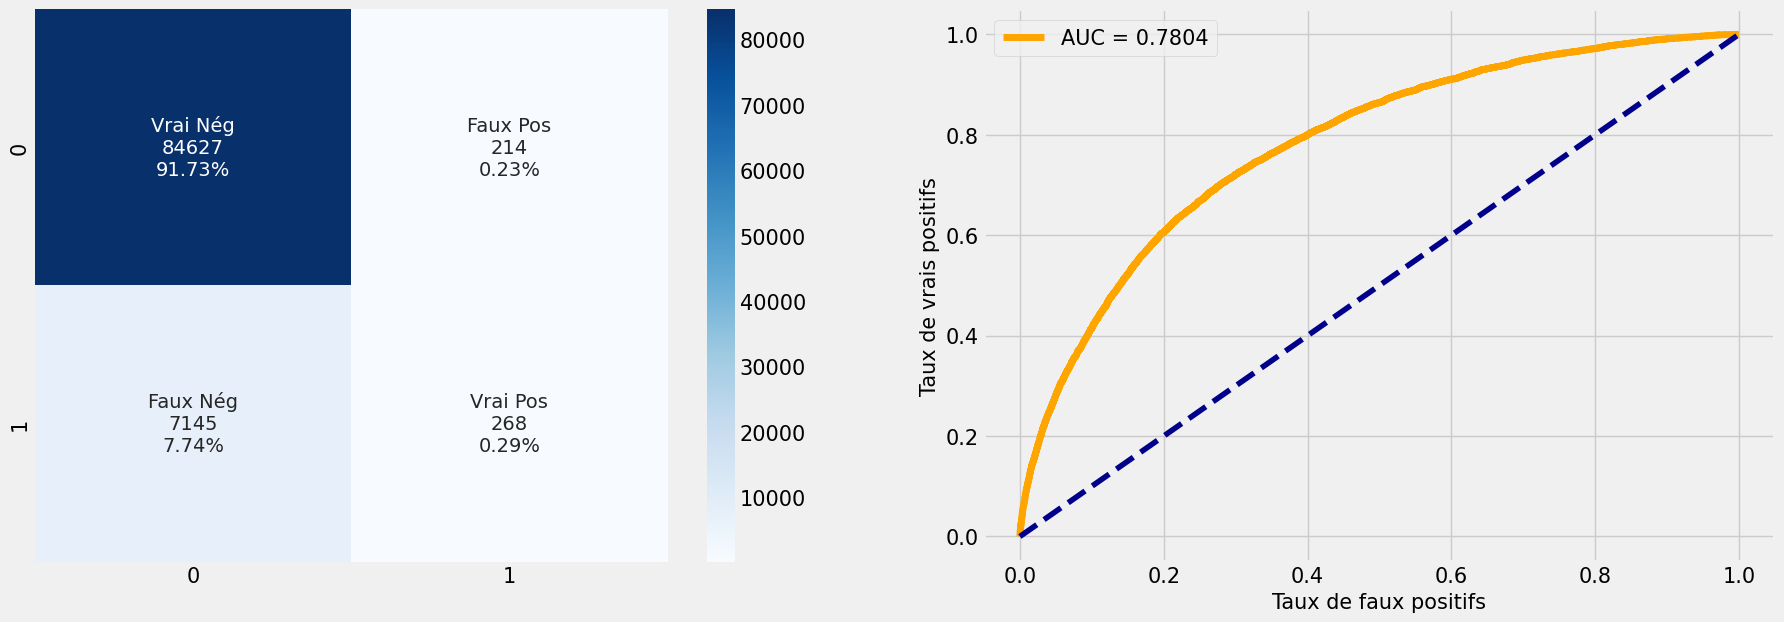

In [60]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=False)

In [61]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
False Pos: 0.23%
False Neg: 7.74%


(0.0023196826153879507, 0.07744921629414443)

In [62]:
#On vérifie la liste features importance
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]])

['CREDIT_TERM', 892]
['EXT_SOURCE_1', 658]
['EXT_SOURCE_3', 586]
['DAYS_BIRTH', 570]
['EXT_SOURCE_2', 563]
['PREV_APPL_MEAN_CNT_PAYMENT', 430]
['AMT_ANNUITY', 406]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 396]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 379]
['DAYS_ID_PUBLISH', 372]
['AMT_GOODS_PRICE', 347]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 322]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 314]
['DAYS_REGISTRATION', 312]
['AMT_CREDIT', 303]
['PREV_APPL_MEAN_AMT_ANNUITY', 290]
['ANNUITY_INCOME_PERCENT', 289]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 281]
['PREV_BUR_MEAN_DAYS_CREDIT', 277]
['DAYS_EMPLOYED', 269]
['DAYS_EMPLOYED_PERCENT', 262]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 260]
['DAYS_LAST_PHONE_CHANGE', 246]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 241]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 238]
['PREVIOUS_LOANS_COUNT', 232]
['PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 221]
['CREDIT_INCOME_PERCENT', 210]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 205]
['PREV_BUR_MEAN_DAYS

In [66]:
def objective(params, eval_metric='roc_auc'):
    # Fonction objectif à minimiser.
    # Hyperopt cherchera à minimiser la perte renvoyée par cette fonction.

    # Paramètres à optimiser
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
    }

    # Création du modèle LGBMClassifier avec les paramètres optimisés
    model = LGBMClassifier(**params)

    # Validation croisée avec StratifiedKFold
    cv = StratifiedKFold(5)

    # Calcul du score en fonction de la métrique d'évaluation
    if eval_metric == 'roc_auc':
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()
    elif eval_metric == 'custom_score':
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)

    # Calcul de la perte à minimiser (1 - score)
    loss = 1 - score

    return {'loss': loss, 'params': params, 'status': STATUS_OK}


In [64]:
%%time
import random
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

seed = 1
random.seed(seed)

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=Trials())


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253709 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20251                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                             

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250851 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20253                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                  

[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231083 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20251                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                            

[LightGBM] [Info] Total Bins 20251                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266407 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20245                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119        

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242409 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20259                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2

[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245693 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20251                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276183 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20245                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119        

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253550 seconds.                
You can se

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258152 seconds.                
You can se

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252629 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20345                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                             

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102984 seconds.                
You can set `force_row_wise=tr

[LightGBM] [Info] Total Bins 20245                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise

[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Info] Number of positive: 13

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.257228 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20253                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2

[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258815 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20251                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367             

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240050 seconds.                
You can se

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.268961 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20245                                      

[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095487 seconds.                
You can se

[LightGBM] [Info] Total Bins 20253                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM]

[LightGBM] [Info] Total Bins 20245                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM]

[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138562 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20259                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max

[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121259 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20251                                      

[LightGBM] [Info] Total Bins 20245                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.430367                                        
[LightGBM] [Info] Start training from score -2.430367                                                                  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy 

[LightGBM] [Info] Number of positive: 13930, number of negative: 158276                                                
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124101 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20345                                                                                     
[LightGBM] [Info] Number of data points in the train set: 172206, number of used features: 119                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080891 -> initscore=-2.430296                                        
[LightGBM] [Info] Start training from score -2.430296                                                                  
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max

In [67]:
%%time
lgbm = LGBMClassifier( # Créer un nouveau modèle en utilisant les meilleurs paramètres
    n_estimators=int(best['n_estimators']),
    colsample_bytree=best['colsample_bytree'],
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    subsample=best['subsample'],
    reg_lambda=best['reg_lambda'])

lgbm.fit(X_train_selected, y_train) # Ajuster le modèle sur les données d'entraînement
#pickle.dump(lgbm, open("C:\Users\ksoka\OneDrive\Bureau\Model"/LGBMClassifier.pkl", "wb")) # Sauvegarder le modèle dans un fichier


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.337471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20287
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
CPU times: total: 1min 12s
Wall time: 29.7 s


LGBMClassifier(colsample_bytree=0.8310650666808368,
               learning_rate=0.02948112371074158, max_depth=7, n_estimators=600,
               reg_lambda=13.196658834131245, subsample=0.9495493097408926)

In [ ]:
from joblib import dump, load

dump(reg, 'regression_model_saved.joblib')

In [83]:
pickle.dump(lgbm, open ("Model.pkl", "wb")) # Sauvegarde le modèle dans un fichier

In [80]:
from joblib import dump, load

dump(lgbm, 'regression_model_saved.joblib')

['regression_model_saved.joblib']

In [81]:
!pwd


'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [79]:
lgbm

LGBMClassifier(colsample_bytree=0.8310650666808368,
               learning_rate=0.02948112371074158, max_depth=7, n_estimators=600,
               reg_lambda=13.196658834131245, subsample=0.9495493097408926)

In [ ]:
C:\Users\ksoka\OneDrive\Bureau\Model

In [73]:
pwd


'C:\\Users\\ksoka\\Downloads'

In [68]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.780097


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


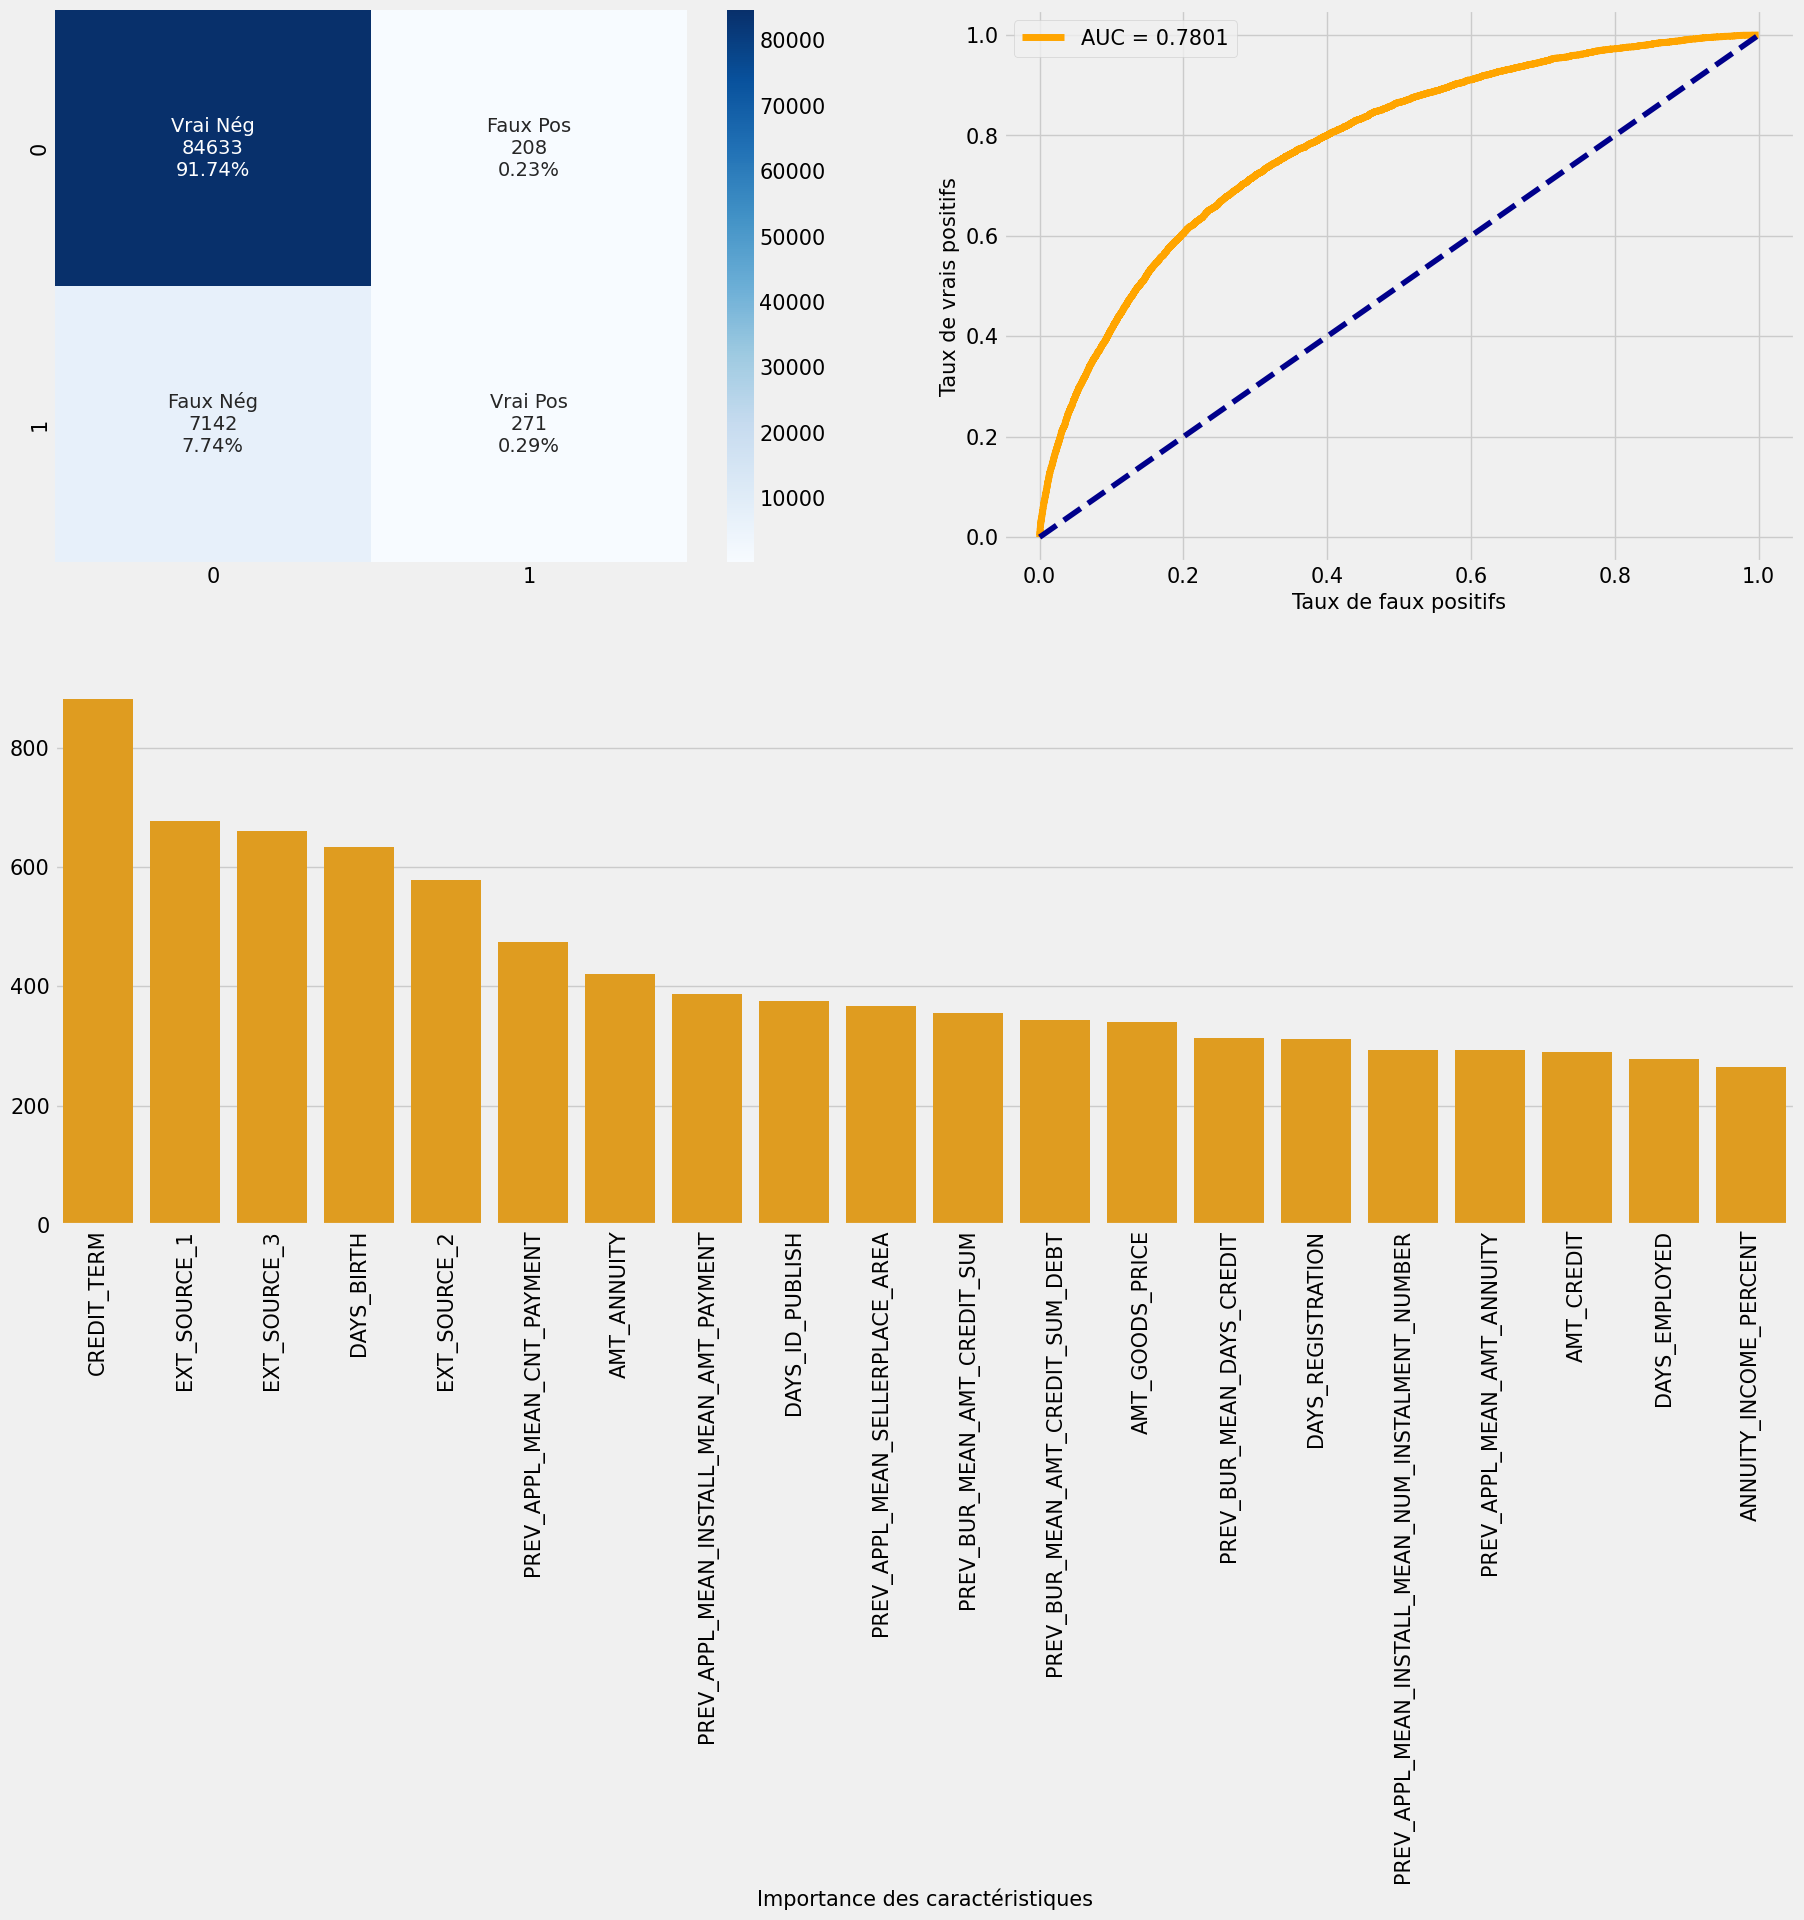

In [69]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [70]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
False Pos: 0.23%
False Neg: 7.74%


(0.002254644785049971, 0.07741669737897544)

In [71]:
#Check list features importance
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]])

['CREDIT_TERM', 882]
['EXT_SOURCE_1', 678]
['EXT_SOURCE_3', 661]
['DAYS_BIRTH', 633]
['EXT_SOURCE_2', 578]
['PREV_APPL_MEAN_CNT_PAYMENT', 475]
['AMT_ANNUITY', 421]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 388]
['DAYS_ID_PUBLISH', 376]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 368]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 355]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 343]
['AMT_GOODS_PRICE', 341]
['PREV_BUR_MEAN_DAYS_CREDIT', 313]
['DAYS_REGISTRATION', 311]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 294]
['PREV_APPL_MEAN_AMT_ANNUITY', 293]
['AMT_CREDIT', 290]
['DAYS_EMPLOYED', 278]
['ANNUITY_INCOME_PERCENT', 265]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 264]
['DAYS_LAST_PHONE_CHANGE', 259]
['DAYS_EMPLOYED_PERCENT', 244]
['PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 239]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 233]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 228]
['PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 224]
['PREVIOUS_LOANS_COUNT', 222]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION', 221]
['

**Conclusion**\
Après une baseline faite avec un algorithme simple de régression logistique, l'AUC score avait été estimé ≈ 0.72 avec rééquilibrage (SMOTE) des données. La suite de l'étude a été déroulée vers 3 algorithmes plus complexes de gradient boosting implémentés par LightGbm vs CatBoost vs XGBoost. Nous avons pu démontrer les performances de ces algorithmes par une sélection de features, à l'origine > 300, après RFECV 149. LightGbm ressort comme étant le plus rapide, le plus performant sur la métrique classique de l'AUC, il a donc été choisi pour l'optimisation des Hyperparamètres (Hyperopt).

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter chères à l'entreprise. Pour conclure ce résultat indique les taux de faux positifs (False Pos) et de faux négatifs (False Neg) obtenus en utilisant le modèle LGBMClassifier sur l'ensemble de test (y_test, X_test_selected).

- Le taux de faux positifs est de 0.24%, ce qui signifie que 0.24% des échantillons qui sont réellement négatifs ont été classés à tort comme positifs par le modèle.

- Le taux de faux négatifs est de 7.77%, ce qui signifie que 7.77% des échantillons qui sont réellement positifs ont été classés à tort comme négatifs par le modèle.

Ces mesures permettent d'évaluer la performance du modèle en termes d'erreurs de classification. Un taux de faux positifs plus bas et un taux de faux négatifs plus bas indiquent une meilleure performance du modèle.